In [14]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import functions as main
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Transform cluttered data

### Merge de todos os dados Macro num só CSV

In [15]:
from pathlib import Path
import glob

path = r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\variables_data"
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

dfs = []
for file in files:
    # Leitura do CSV
    data = pd.read_csv(file)
    
    # Ajuste do nome da coluna de datas para um nome consistente
    if 'DATE' in data.columns:
        data.rename(columns={'DATE': 'Date'}, inplace=True)
    
    if 'date' in data.columns:
        data.rename(columns={'date': 'Date'}, inplace=True)

    data["Date"] = pd.to_datetime(data.Date)

    # Definir a coluna de datas como índice
    data.set_index('Date', inplace=True)
    
    # Adicionar o DataFrame à lista
    dfs.append(data)

# Juntar todos os DataFrames usando o método "outer"
df = pd.concat(dfs, axis=1, join='outer')

In [16]:
df_daily = df.resample("D").last()

In [17]:
df_daily_mod = df_daily.loc["2011-1-1":"2024-7-31"]
df_daily_mod

,BalanceSheet_global,BalanceSheet_usa,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,GDP_usa,HashRate,M2_Liquidity,EURUSD=X,DX-Y.NYB,...,^TNX,^VIX,CL=F,Miners_Revenue_USD,Nr_Tx_Block,Nr_Transactions,Nr_Addresses,BTC_PageViews,Crypto_PageViews,BTC_Supply
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,NaN,NaN,0.300,14484.162,3756.462,15351.448,0.128,NaN,NaN,NaN,...,NaN,NaN,NaN,2775.027,3.641,659.000,NaN,NaN,NaN,5029550.000
2011-01-02,NaN,NaN,0.300,14484.162,7008.423,NaN,0.130,NaN,NaN,NaN,...,NaN,NaN,NaN,2775.027,3.251,569.000,740.000,NaN,NaN,5038300.000
2011-01-03,NaN,NaN,0.295,16307.421,7795.668,NaN,0.133,8888.500,1.336,79.130,...,3.342,17.610,91.550,2340.218,7.231,1128.000,1023.000,NaN,NaN,5046100.000
2011-01-04,NaN,NaN,0.299,16307.421,3301.215,NaN,0.115,NaN,1.336,79.440,...,3.346,17.380,89.380,2115.009,6.943,979.000,907.000,NaN,NaN,5053150.000
2011-01-05,11809.998,2436064.000,0.299,16307.421,5556.873,NaN,0.122,NaN,1.332,80.260,...,3.483,17.020,90.300,2370.028,8.506,1310.000,1111.000,NaN,NaN,5060850.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,NaN,NaN,67904.550,82047728459932.734,4232975746.964,NaN,628106664.453,NaN,NaN,NaN,...,NaN,NaN,NaN,33621812.773,2894.351,445730.000,508959.000,8248.000,33.000,19732050.000
2024-07-28,NaN,NaN,68252.750,82047728459932.750,2767696675.789,NaN,603634976.228,NaN,NaN,NaN,...,NaN,NaN,NaN,32416704.844,5092.588,753703.000,431944.000,8037.000,32.000,19732512.500
2024-07-29,NaN,NaN,66782.780,82047728459932.625,9902659739.017,NaN,725993417.355,NaN,1.085,104.560,...,4.178,16.600,75.810,40280474.147,4641.174,826129.000,543529.000,6953.000,56.000,19733068.750


In [18]:
df_weekly_mod = df_daily_mod.resample('W-FRI').last() # close semanal à sexta feira

In [19]:
df_weekly_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 709 entries, 2011-01-07 to 2024-08-02
Freq: W-FRI
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BalanceSheet_global  705 non-null    float64
 1   BalanceSheet_usa     706 non-null    float64
 2   BTC_USD              709 non-null    float64
 3   Mining_Difficulty    709 non-null    float64
 4   USD_OnChain_Volume   707 non-null    float64
 5   GDP_usa              53 non-null     float64
 6   HashRate             709 non-null    float64
 7   M2_Liquidity         705 non-null    float64
 8   EURUSD=X             709 non-null    float64
 9   DX-Y.NYB             709 non-null    float64
 10  SPY                  709 non-null    float64
 11  QQQ                  709 non-null    float64
 12  IWDA.AS              709 non-null    float64
 13  GLD                  709 non-null    float64
 14  TLT                  709 non-null    float64
 15  ^TNX     

In [20]:
df_weekly_mod.isna().sum()

BalanceSheet_global      4
BalanceSheet_usa         3
BTC_USD                  0
Mining_Difficulty        0
USD_OnChain_Volume       2
GDP_usa                656
HashRate                 0
M2_Liquidity             4
EURUSD=X                 0
DX-Y.NYB                 0
SPY                      0
QQQ                      0
IWDA.AS                  0
GLD                      0
TLT                      0
^TNX                     0
^VIX                     0
CL=F                     0
Miners_Revenue_USD       0
Nr_Tx_Block              0
Nr_Transactions          0
Nr_Addresses             0
BTC_PageViews          234
Crypto_PageViews       234
BTC_Supply               0
dtype: int64

In [21]:
df_weekly_mod.interpolate(method='linear', inplace=True)
df_weekly_mod = df_weekly_mod.loc[df_weekly_mod.index[1]:]

In [22]:
df_weekly_mod.isna().sum()

BalanceSheet_global      0
BalanceSheet_usa         0
BTC_USD                  0
Mining_Difficulty        0
USD_OnChain_Volume       0
GDP_usa                  0
HashRate                 0
M2_Liquidity             0
EURUSD=X                 0
DX-Y.NYB                 0
SPY                      0
QQQ                      0
IWDA.AS                  0
GLD                      0
TLT                      0
^TNX                     0
^VIX                     0
CL=F                     0
Miners_Revenue_USD       0
Nr_Tx_Block              0
Nr_Transactions          0
Nr_Addresses             0
BTC_PageViews          233
Crypto_PageViews       233
BTC_Supply               0
dtype: int64

In [23]:
df_weekly_mod.to_csv(f"df_weekly.csv", date_format='%Y-%m-%d')

# Descriptive analysis

In [48]:
opencsv = pd.read_csv(r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\df_weekly.csv", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.asfreq(pd.infer_freq(opencsv.index))
opencsv = opencsv.astype(float)

In [49]:
pd.set_option('float_format', '{:.3f}'.format)
opencsv.describe().T

,count,mean,std,min,25%,50%,75%,max
BalanceSheet_global,708.000,17356.309,3661.233,11806.220,14594.438,16567.991,20853.996,23522.830
BalanceSheet_usa,708.000,5225912.531,2030285.106,2425164.000,3936465.250,4463444.500,7334178.250,8965487.000
BTC_USD,708.000,12651.790,18065.323,0.400,255.170,3772.620,19324.755,69903.720
Mining_Difficulty,708.000,13471654787449.916,21091514676422.969,16307.421,11431343972.299,1271897062328.000,19302229490721.500,88104191118792.812
USD_OnChain_Volume,708.000,1856625192.157,2679674679.983,8826.567,56205620.433,707708482.619,2623470974.950,17072634339.063
GDP_usa,708.000,20724.253,3824.422,15368.622,17710.820,20048.830,23145.940,28269.174
HashRate,708.000,97556434.132,153997155.234,0.141,86050.856,8738622.881,136984025.089,676117474.022
M2_Liquidity,708.000,14844.036,4222.849,8789.400,11342.200,13745.050,19736.325,22048.800
EURUSD=X,708.000,1.183,0.111,0.975,1.098,1.141,1.275,1.484
DX-Y.NYB,708.000,92.698,9.119,72.930,82.740,94.955,98.658,113.310


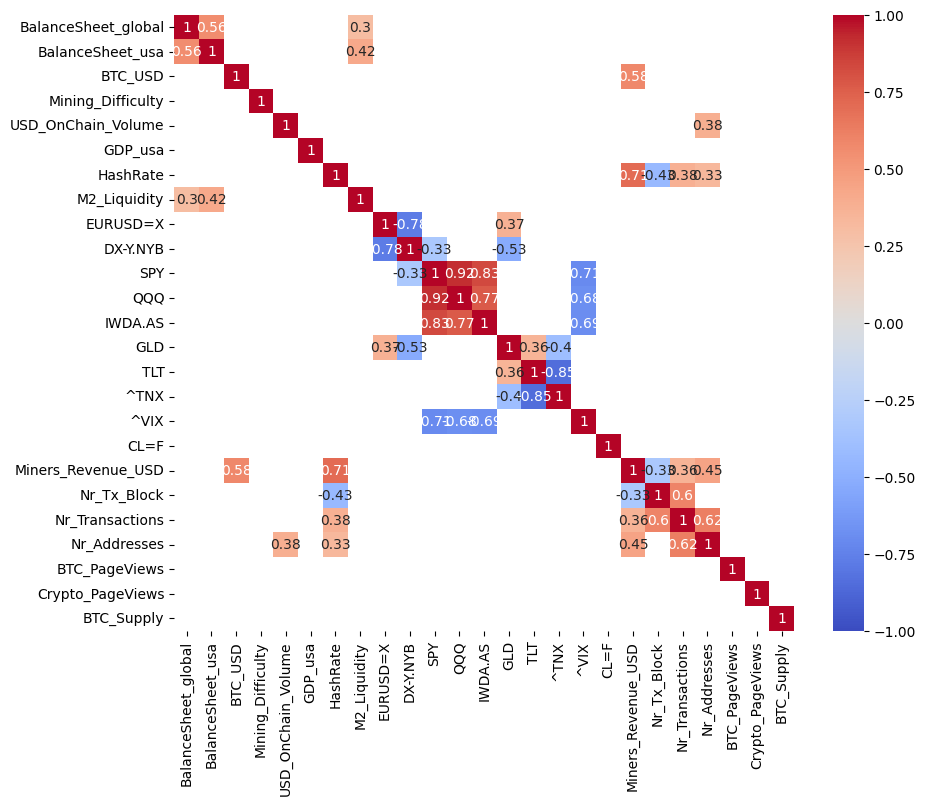

In [26]:
main.correlation_map(df=opencsv, threshold=0.3)

# OLS data Prep

In [27]:
opencsv = pd.read_csv(r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\df_weekly.csv", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.asfreq(pd.infer_freq(opencsv.index))
opencsv = opencsv.astype(float)

In [ ]:
opencsv

In [28]:
opencsv.columns

Index(['BalanceSheet_global', 'BalanceSheet_usa', 'BTC_USD',
       'Mining_Difficulty', 'USD_OnChain_Volume', 'GDP_usa', 'HashRate',
       'M2_Liquidity', 'EURUSD=X', 'DX-Y.NYB', 'SPY', 'QQQ', 'IWDA.AS', 'GLD',
       'TLT', '^TNX', '^VIX', 'CL=F', 'Miners_Revenue_USD', 'Nr_Tx_Block',
       'Nr_Transactions', 'Nr_Addresses', 'BTC_PageViews', 'Crypto_PageViews',
       'BTC_Supply'],
      dtype='object')

### Linear trend check

In [29]:
import plotly.express as px

def check_linearity(df, dependent_variable):
    for column in df.columns:
        if column != dependent_variable:
            df_pct_ret = df.pct_change().ffill()

            # Fazer scatter plot
            fig = px.scatter(df_pct_ret, x=df[column], y=df[dependent_variable], width=600, height=400, 
                             trendline="ols", trendline_color_override="black", title='OLS trend line')

            fig.update_layout(xaxis=dict(title=column), yaxis = dict(title=dependent_variable), template='seaborn').show()

In [ ]:
dependent_variable = "BTC_USD"

check_linearity(opencsv, dependent_variable)

## Normality Tests

Text(0.5, 1.0, 'Distribution of Bitcoin returns in $log$ scale')

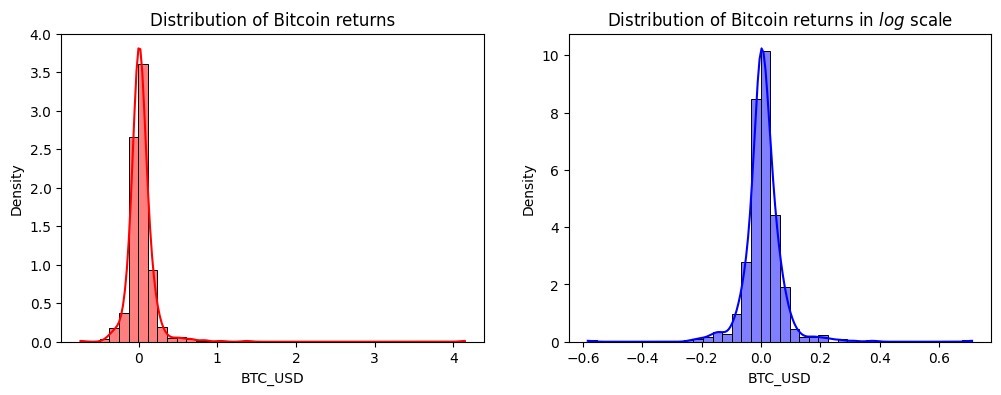

In [30]:
import seaborn as sns

btc_returns = opencsv["BTC_USD"].pct_change().dropna()
btc_log_returns = np.log10(opencsv["BTC_USD"]).diff().dropna()

f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.histplot(btc_returns,bins=40,color='r',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin returns')

ax=f.add_subplot(122)
sns.histplot(btc_log_returns,bins=40,color='b',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin returns in $log$ scale')

### Box -Cox transformation
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests. All that we need to perform this transformation is to find lambda value and apply the rule shown below to your variable.  
$$\mathbf{ \begin {cases}\frac {y^\lambda - 1}{\lambda},& y_i\neg=0 \\
 log(y_i) & \lambda = 0 \end{cases}}$$
 The trick of Box-Cox transformation is to find lambda value, however in practice this is quite affordable. The following function returns the transformed variable, lambda value,confidence interval

In [ ]:
from scipy.stats import boxcox
BTC_USD_BoxCox,lam, ci= boxcox(opencsv["BTC_USD"],alpha=0.05)

ci,lam

In [ ]:
import seaborn as sns

# Convert numpy array to a DataFrame
BTC_USD_BoxCox_df = pd.DataFrame(BTC_USD_BoxCox, index=opencsv.index, columns=["BTC_USD_BoxCox"])

btc_BoxCox_returns = BTC_USD_BoxCox_df["BTC_USD_BoxCox"].pct_change().dropna()

f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.histplot(btc_returns,bins=40,color='r',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin returns')

ax=f.add_subplot(122)
sns.histplot(btc_BoxCox_returns,bins=40,color='b',ax=ax, kde=True, stat='density')
ax.set_title('Distribution of Bitcoin Box Cox returns')

### Log Df

In [40]:
# transformacao logaritcmica de todas as colunas

halving16 = "2016-07-09"

metade1 = opencsv.copy()
metade1 = metade1.loc[:halving16]
metade1 = metade1.drop(columns=["BTC_PageViews", "Crypto_PageViews"]) # removo porque nao tem observacoes

metade2 = opencsv.copy()
metade2 = metade2.loc[halving16:]

log_df = np.log10(metade2) 

In [ ]:
main.correlation_map(df=log_df, threshold=0.3)

In [ ]:
log_df.info()

In [41]:
log_df.isna().sum()

BalanceSheet_global    0
BalanceSheet_usa       0
BTC_USD                0
Mining_Difficulty      0
USD_OnChain_Volume     0
GDP_usa                0
HashRate               0
M2_Liquidity           0
EURUSD=X               0
DX-Y.NYB               0
SPY                    0
QQQ                    0
IWDA.AS                0
GLD                    0
TLT                    0
^TNX                   0
^VIX                   0
CL=F                   0
Miners_Revenue_USD     0
Nr_Tx_Block            0
Nr_Transactions        0
Nr_Addresses           0
BTC_PageViews          0
Crypto_PageViews       0
BTC_Supply             0
dtype: int64

### Winsorozation

In [42]:
from scipy.stats.mstats import winsorize

winsorized_df = log_df.copy()

winsorized_df = winsorized_df.apply(lambda col: winsorize(col, (0.01, 0.01)))
winsorized_df.head()

,BalanceSheet_global,BalanceSheet_usa,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,GDP_usa,HashRate,M2_Liquidity,EURUSD=X,DX-Y.NYB,...,^TNX,^VIX,CL=F,Miners_Revenue_USD,Nr_Tx_Block,Nr_Transactions,Nr_Addresses,BTC_PageViews,Crypto_PageViews,BTC_Supply
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-15,4.205,6.651,2.822,11.329,8.271,4.278,6.175,4.111,0.046,1.985,...,0.202,1.103,1.662,6.070,3.204,5.335,5.581,3.934,1.863,7.199
2016-07-22,4.204,6.651,2.814,11.329,8.219,4.278,6.175,4.111,0.043,1.989,...,0.196,1.080,1.645,6.047,3.235,5.345,5.581,3.991,1.964,7.199
2016-07-29,4.205,6.650,2.817,11.329,8.191,4.278,6.193,4.111,0.045,1.980,...,0.164,1.074,1.619,6.115,3.197,5.364,5.581,3.909,1.919,7.199
2016-08-05,4.206,6.650,2.769,11.329,8.191,4.278,6.229,4.111,0.047,1.983,...,0.199,1.057,1.621,6.094,3.131,5.358,5.582,3.976,2.310,7.199
2016-08-12,4.206,6.650,2.769,11.329,8.181,4.278,6.175,4.113,0.047,1.981,...,0.180,1.063,1.648,6.054,3.194,5.367,5.590,3.890,2.083,7.199


In [43]:
winsorized_df.shape

(421, 25)

In [ ]:
dependent_variable = "BTC_USD"

check_linearity(winsorized_df, dependent_variable)

### Lagged variables

In [44]:
# Add 1 and 2 Lagged Variable

lagged_df = winsorized_df.copy()

for column in lagged_df.columns:
    lagged_df[f'L1.{column}'] = lagged_df[column].shift(1)
    lagged_df[f'L2.{column}'] = lagged_df[column].shift(2)

In [45]:
lagged_df = lagged_df.iloc[2:]
lagged_df.head(3)

,BalanceSheet_global,BalanceSheet_usa,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,GDP_usa,HashRate,M2_Liquidity,EURUSD=X,DX-Y.NYB,...,L1.Nr_Transactions,L2.Nr_Transactions,L1.Nr_Addresses,L2.Nr_Addresses,L1.BTC_PageViews,L2.BTC_PageViews,L1.Crypto_PageViews,L2.Crypto_PageViews,L1.BTC_Supply,L2.BTC_Supply
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-29,4.205,6.650,2.817,11.329,8.191,4.278,6.193,4.111,0.045,1.980,...,5.345,5.335,5.581,5.581,3.991,3.934,1.964,1.863,7.199,7.199
2016-08-05,4.206,6.650,2.769,11.329,8.191,4.278,6.229,4.111,0.047,1.983,...,5.364,5.345,5.581,5.581,3.909,3.991,1.919,1.964,7.199,7.199
2016-08-12,4.206,6.650,2.769,11.329,8.181,4.278,6.175,4.113,0.047,1.981,...,5.358,5.364,5.582,5.581,3.976,3.909,2.310,1.919,7.199,7.199


In [ ]:
test_linearity_df = lagged_df.copy()
test_linearity_df = test_linearity_df.iloc[:, 19:]
test_linearity_df["BTC_USD"] = lagged_df["BTC_USD"]

#check_linearity(test_linearity_df, dependent_variable)

In [ ]:
#check_linearity(test_linearity_df, dependent_variable)

# Split cycle Dfs

In [46]:
## ciclos
halving12 = "2012-11-28"
halving16 = "2016-07-09"
halving20 = "2020-05-11"
halving24 = "2024-04-19"

prep_df=lagged_df.copy()

ciclo1 = prep_df.loc[:halving12]
ciclo2 = prep_df.loc[halving12:halving16]
ciclo3 = prep_df.loc[halving16:halving20]
ciclo4 = prep_df.loc[halving20:halving24]
ciclo5 = prep_df.loc[halving24:]

In [39]:
# 1 Metade
for i in range(1, 3):  # Loop from 1 to 5 to match your DataFrame names
    df = globals()[f'ciclo{i}']  # Access each DataFrame using its name
    df.to_csv(f"ciclo{i}_df.csv", date_format='%Y-%m-%d')  # Save each DataFrame with a dynamic filename

In [47]:
# 2 Metade
for i in range(3, 6):  # Loop from 1 to 5 to match your DataFrame names
    df = globals()[f'ciclo{i}']  # Access each DataFrame using its name
    df.to_csv(f"ciclo{i}_df.csv", date_format='%Y-%m-%d')  # Save each DataFrame with a dynamic filename